In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import math
import io
import requests

In [ ]:
# load data

# url from which data is being loaded onto our dataframe
url = 'https://www.stat.cmu.edu/%7Elarry/all-of-statistics/=data/glass.dat'

# ssl verification was failing, so had to disable to proceed
response = requests.get(url, verify=False)

# Raise an exception in case of a bad status code
response.raise_for_status()

# Skip the first line as it has one column less and causes error while parsing
lines = response.text.split('\n')
data_text = '\n'.join(lines[1:])

# Read the data into a pandas DataFrame
# use only 2 columns (RI(1)and Al(4))

# df = pd.read_csv(response, sep='\s+', header=None, usecols=[1, 4], skiprows=1)
df = pd.read_csv(io.StringIO(data_text), sep='\s+', header=None, usecols=[1, 4])

# respective column names
df.columns = ['RI','Al']

df.head()

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.stat.cmu.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,RI,Al
0,3.01,1.10
1,-0.39,1.36
2,-1.82,1.54
3,-0.34,1.29
4,-0.58,1.24


In [ ]:
# y is the refractive index of material (our response value)
Y = df['RI']
# x is aluminium content (our input)
X = df['Al']

# for deciding starting and end points of the plots
x_min = min(X)
x_max = max(X)

In [ ]:
#kernel functions

# 1 - epanechnikov
def epanechnikov_kernel(x):
  return (3/4)*max((1-x**2), 0)

#2 - gaussian
def gaussian_kernel(x):
  exp = np.exp(-(x**2)/2)
  return ((1/(2*np.pi))**0.5)*exp

# risk - to be used for cross-validation
def risk(y_true, y_pred):
  return np.mean((y_true - y_pred)**2)

In [ ]:
# the density estimate-1
def m_gaussian(x, X, Y, h):
  # sum - 1
  sigma = sum(gaussian_kernel((x - X[i]) / h) for i in range(len(X)))
  # weights - 1
  if sigma != 0:
    w_gaussian = [gaussian_kernel((x-X[i])/h)/sigma for i in range(len(X))]
    return np.dot(w_gaussian, Y)
  else:
    return np.mean(Y)

# the density estimate-2
def m_epanechnikov(x, X, Y, h):
  # sum - 2
  sigma = sum(epanechnikov_kernel((x - X[i]) / h) for i in range(len(X)))
  # weights - 2
  if sigma != 0:
    w_epanechnikov = [epanechnikov_kernel((x-X[i])/h)/sigma for i in range(len(X))]
    return np.dot(w_epanechnikov, Y)
  else:
    return np.mean(Y)

In [ ]:

# Cross-Validation
def k_fold(X, Y, k, bw_limit):
  # shuffle data
  indices = np.arange(len(X))
  np.random.shuffle(indices)
  X = X[indices]
  Y = Y[indices]

  # split data into k folds
  fold_size = len(X) // k
  # 2D-array: for each test_train split, risk is calculated for each bandwidth
  risk_gaussian = [[] for i in range(k)]
  risk_epanechnikov = [[] for i in range(k)]

  for i in range(k):
    start = i * fold_size
    # last batch size may vary if len(X) is not a multiple of k
    if (i == k-1):
      end = len(X)
    else:
      end = start + fold_size

    # test set
    x_test = X[start:end]
    y_test = Y[start:end]

    # training set
    x_train = np.concatenate([X[:start], X[end:]])
    y_train = np.concatenate([Y[:start], Y[end:]])

    for bw in np.arange(0.01, bw_limit, 0.01):
      # for each bw, find y_pred for a particular fold
      y_pred_gaussian = [m_gaussian(xt, x_train, y_train, bw) for xt in x_test]
      y_pred_epanechnikov = [m_epanechnikov(xt, x_train, y_train, bw) for xt in x_test]
      risk_gaussian[i].append(risk(y_test, y_pred_gaussian))
      risk_epanechnikov[i].append(risk(y_test, y_pred_epanechnikov))

  # take average of all training folds, along each bandwidth
  risk_gaussian = np.mean(risk_gaussian, axis=0)
  risk_epanechnikov = np.mean(risk_epanechnikov, axis=0)

  # bandwidth corresponding to minimum risk for both kernels
  h_min_gaussian = 0.01*(1 + np.argmin(risk_gaussian))
  h_min_epanechnikov = 0.01*(1 + np.argmin(risk_epanechnikov))

  return risk_gaussian, risk_epanechnikov, h_min_gaussian, h_min_epanechnikov

# to plot risk vs bw
def plot_risk(risk_list, bw_limit):
  bw_values = np.arange(0.01, bw_limit, 0.01)
  plt.plot(bw_values, risk_list)
  plt.tick_params(axis='both', which='major', labelsize=10)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Bandwidth')
  plt.ylabel('Risk')

# to plot data points and m(x)

def plot_m_gaussian(X, Y, bw):
  plt.scatter(X, Y, label = "Data", s = 10)
  x = np.linspace(x_min - 0.01, x_max + 0.01, 1000)
  y = [m_gaussian(xt, X, Y, bw) for xt in x]
  plt.plot(x, y, label = "Gaussian Kernel Estimate", c = 'orange')
  plt.tick_params(axis='both', which='major', labelsize=10)
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.xlabel('Aluminium Content')
  plt.ylabel('Refractive Index')

def plot_m_epanechnikov(X, Y, bw):
  plt.scatter(X, Y, label = "Data", s = 10)
  x = np.linspace(x_min - 0.01, x_max + 0.01, 1000)
  y = [m_epanechnikov(xt, X, Y, bw) for xt in x]
  plt.plot(x, y, label = "Epanechnikov Kernel Estimate", c = 'orange')
  plt.xlabel('Aluminium Content')
  plt.ylabel('Refractive Index')


In [ ]:
#check results to decide h values for the other subplots
k = 10
bw_limit = 2.0
risk_gaussian, risk_epanechnikov, h_min_gaussian, h_min_epanechnikov = k_fold(X, Y, k, bw_limit)

print("Optimum bandwidth for Gaussian Kernel: ", h_min_gaussian)
print("Optimum bandwidth for Epanechnikov Kernel: ", h_min_epanechnikov)


Optimum bandwidth for Gaussian Kernel:  0.14
Optimum bandwidth for Epanechnikov Kernel:  0.34


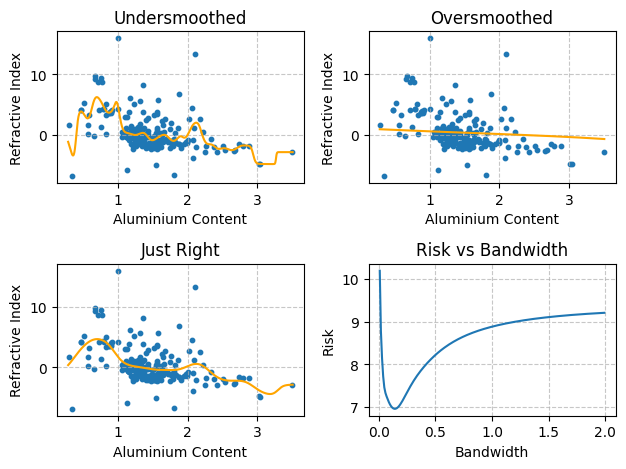

In [ ]:
# gaussian subplots: for k = 10

# undersmoothed/overfitted
plt.subplot(2,2,1)
#chosen based on initial risk vs bw plot
bw = 0.05
plot_m_gaussian(X, Y, bw)
plt.title("Undersmoothed")

# over-smoothed / underfitted
plt.subplot(2,2,2)
#chosen based on initial risk vs bw plot
bw = 1.00
plot_m_gaussian(X, Y, bw)
plt.title("Oversmoothed")

# just-right (using cross-validation)
plt.subplot(2,2,3)
#chosen based on initial risk vs bw plot
plot_m_gaussian(X, Y, h_min_gaussian)
plt.title("Just Right")

# risk vs bandwidth (using cross-validation)
plt.subplot(2,2,4)
plot_risk(risk_gaussian, bw_limit)
plt.title("Risk vs Bandwidth")

plt.tight_layout()
# save accordingly
plt.savefig('gaussian_kernel_regression.png')

plt.show()

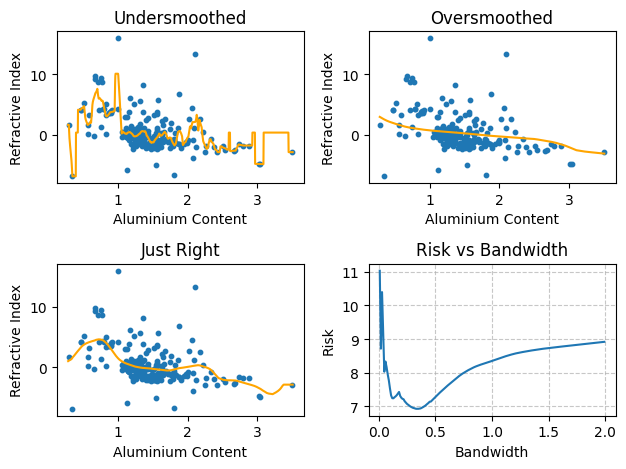

In [ ]:
# epanechnikov subplots: for k = 10

# undersmoothed/overfitted
plt.subplot(2,2,1)
#chosen based on initial risk vs bw plot
bw = 0.05
plot_m_epanechnikov(X, Y, bw)
plt.title("Undersmoothed")

# over-smoothed / underfitted
plt.subplot(2,2,2)
#chosen based on initial risk vs bw plot
bw = 1.00
plot_m_epanechnikov(X, Y, bw)
plt.title("Oversmoothed")

# just-right (using cross-validation)
plt.subplot(2,2,3)
plot_m_epanechnikov(X, Y, h_min_epanechnikov)
plt.title("Just Right")

# risk vs bandwidth (using cross-validation)
plt.subplot(2,2,4)
plot_risk(risk_epanechnikov, bw_limit)
plt.title("Risk vs Bandwidth")

plt.tight_layout()

plt.savefig('epanechnikov_kernel_regression.png')

plt.show()